In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv("sample.csv")
y = data[' Label']
X = data.drop(columns=['Unnamed: 0', 'Flow ID', ' Timestamp', ' Label'])
del data
gc.collect()

0

In [5]:
y.value_counts()

MSSQL      100000
SSDP       100000
UDPLag     100000
Portmap    100000
DNS        100000
TFTP       100000
UDP        100000
LDAP       100000
Syn        100000
NetBIOS    100000
SNMP       100000
NTP        100000
BENIGN     100000
WebDDoS       439
Name:  Label, dtype: int64

In [4]:
y_num = y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

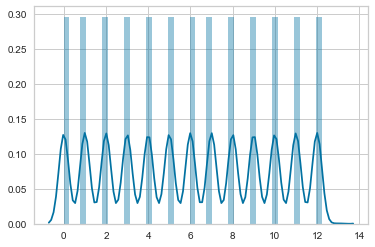

In [7]:
sns.distplot(y_num)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300439 entries, 0 to 1300438
Data columns (total 84 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0    Source IP                    1300439 non-null  object 
 1    Source Port                  1300439 non-null  int64  
 2    Destination IP               1300439 non-null  object 
 3    Destination Port             1300439 non-null  int64  
 4    Protocol                     1300439 non-null  int64  
 5    Flow Duration                1300439 non-null  int64  
 6    Total Fwd Packets            1300439 non-null  int64  
 7    Total Backward Packets       1300439 non-null  int64  
 8   Total Length of Fwd Packets   1300439 non-null  float64
 9    Total Length of Bwd Packets  1300439 non-null  float64
 10   Fwd Packet Length Max        1300439 non-null  float64
 11   Fwd Packet Length Min        1300439 non-null  float64
 12   Fwd Packet Length Mean     

In [10]:
src_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in X[' Source IP']]
X[' Source IP'] = pd.Series(src_ip)

dst_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in X[' Destination IP']]
X[' Destination IP'] = pd.Series(dst_ip)

# do data_X['SimillarHTTP'].value_counts()
X['SimillarHTTP'][X['SimillarHTTP'] != 0] = 1   

# todo: scale before preprocessing
X['Flow Bytes/s'][np.isinf(X['Flow Bytes/s'])] = 9999999999
X['Flow Bytes/s'][X['Flow Bytes/s'].isna()] = X['Flow Bytes/s'].mean()

X[' Flow Packets/s'][np.isinf(X[' Flow Packets/s'])] = 5000000

### ANOVA F-value

In [16]:
from sklearn.feature_selection import f_classif

In [15]:
X['SimillarHTTP'] = X['SimillarHTTP'].astype(int)

In [17]:
fvalue_selector = SelectKBest(f_classif, k=10)
features_kbest = fvalue_selector.fit_transform(X, y)

In [64]:
F, pval = f_classif(X,y)

In [65]:
F[np.isnan(F)] = 0

In [66]:
idx = np.argsort(F, axis=0)[::-1]
F_des = sorted(F, reverse=True)

In [68]:
feature_names = list(X.columns) 
y_pos = np.arange(20)
performance = F_des[:20]

xlabel = []
for value in idx:
    xlabel.append(feature_names[value])

In [75]:
xlabel

[' Avg Fwd Segment Size',
 ' Fwd Packet Length Mean',
 ' Min Packet Length',
 ' Fwd Packet Length Min',
 ' Average Packet Size',
 ' Packet Length Mean',
 ' Fwd Packet Length Max',
 ' ACK Flag Count',
 ' Protocol',
 ' Inbound',
 ' Source Port',
 ' Max Packet Length',
 ' Destination IP',
 'SimillarHTTP',
 ' URG Flag Count',
 ' Down/Up Ratio',
 ' act_data_pkt_fwd',
 'Fwd Packets/s',
 'Init_Win_bytes_forward',
 ' Subflow Fwd Bytes',
 'Total Length of Fwd Packets',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Bwd Packet Length Min',
 ' CWE Flag Count',
 ' RST Flag Count',
 'Fwd PSH Flags',
 ' Avg Bwd Segment Size',
 ' Bwd Packet Length Mean',
 ' Packet Length Std',
 ' Flow IAT Mean',
 ' Fwd Packet Length Std',
 ' Fwd IAT Mean',
 ' Flow IAT Std',
 ' Bwd Packet Length Std',
 ' Fwd IAT Std',
 ' Destination Port',
 'Bwd Packet Length Max',
 ' Flow Duration',
 ' Flow IAT Max',
 'Fwd IAT Total',
 ' Fwd IAT Max',
 ' Init_Win_bytes_backward',
 ' Idle Max',
 'Idle Mean',
 ' Idle Min',
 'Bwd IAT Total',
 

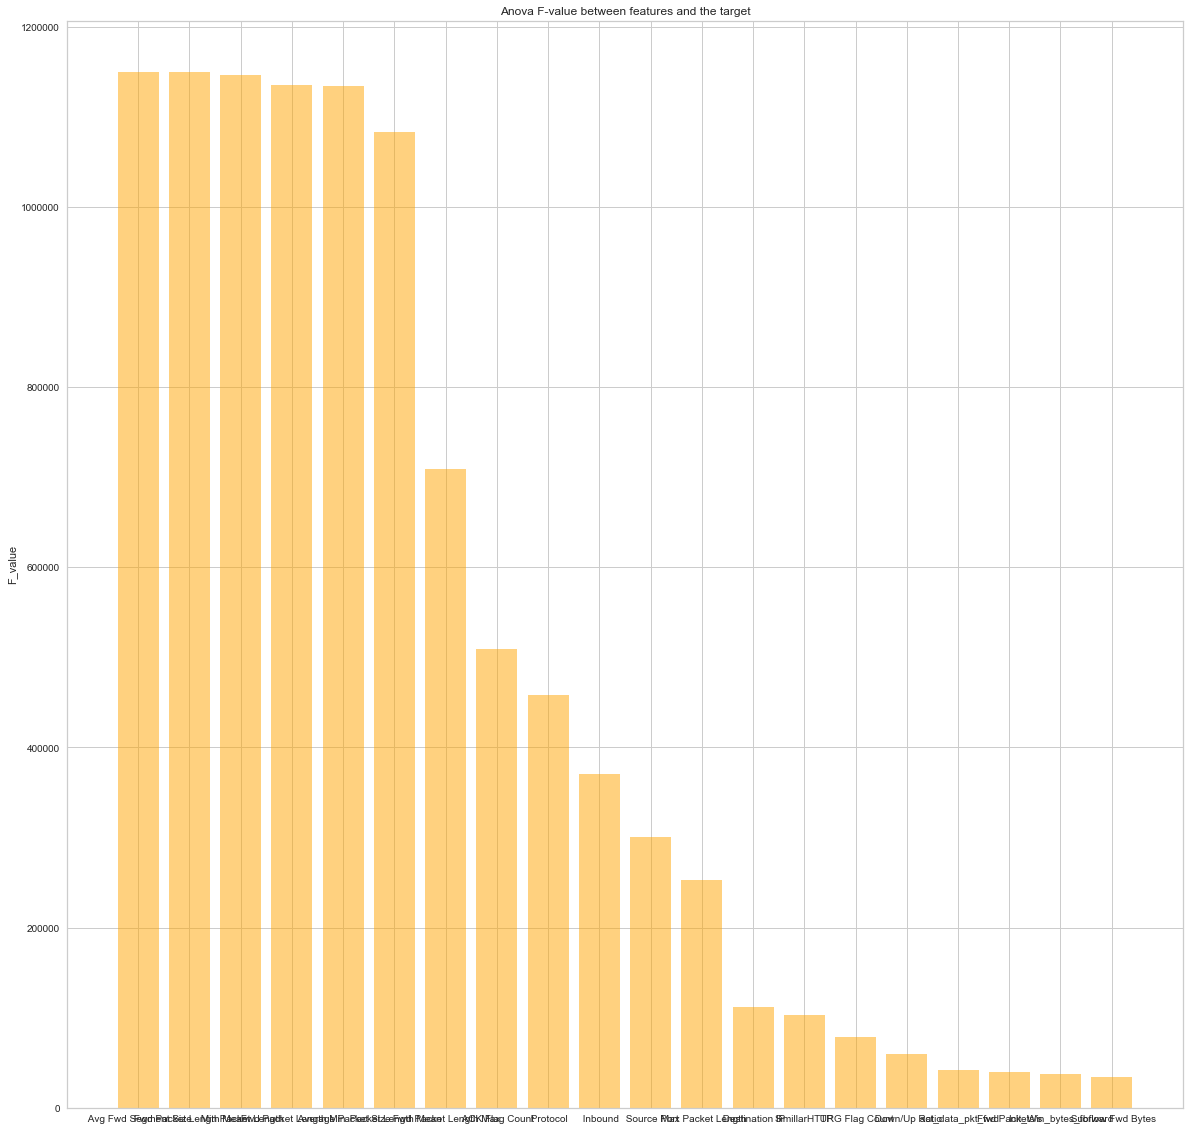

In [71]:
plt.figure(figsize=(20,20))
plt.bar(y_pos, performance, width=0.8, align='center', alpha=0.5, color="orange")
plt.xticks(y_pos, xlabel[:20])
plt.ylabel('F_value')
plt.title('Anova F-value between features and the target')

plt.show()

### feature selection recursively

In [93]:
from sklearn.feature_selection import SelectKBest

In [94]:
fvalue_selector = SelectKBest(f_classif, k=20)
features_kbest = fvalue_selector.fit_transform(X, y)

In [100]:
mask = fvalue_selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
new_features

[' Source Port',
 ' Destination IP',
 ' Protocol',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 'Fwd Packets/s',
 ' Min Packet Length',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' ACK Flag Count',
 ' URG Flag Count',
 ' Down/Up Ratio',
 ' Average Packet Size',
 ' Avg Fwd Segment Size',
 ' Subflow Fwd Bytes',
 'Init_Win_bytes_forward',
 ' act_data_pkt_fwd',
 'SimillarHTTP',
 ' Inbound']

### Some EDA

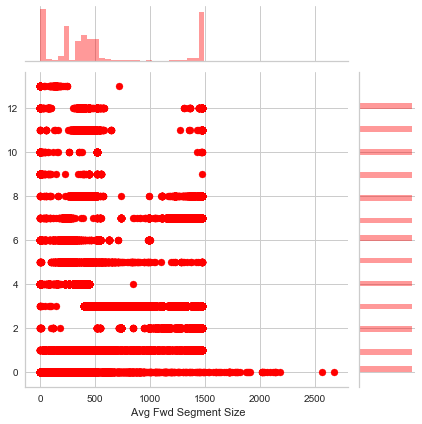

In [74]:
sns.jointplot(X[' Avg Fwd Segment Size'], y_num, color='red')

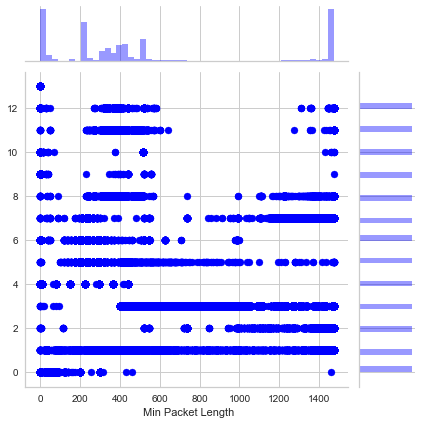

In [77]:
sns.jointplot(X[' Min Packet Length'], y_num, color='blue')

### Corrleation between features

In [88]:
corrs = X.corr()
attrs = corrs.iloc[:-1, :-1]              

threshold = 0.7                      

# transform correlations into a dictionary
sig_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]).unstack().dropna().to_dict()
# generate correlation dataframe
uni_sig_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), sig_corrs[key]) for key in sig_corrs])), 
                             columns=['Attribute Pair', 'Correlation'])
# sort by absolute correlation value descendingly
uni_sig_corrs = uni_sig_corrs.iloc[abs(uni_sig_corrs['Correlation']).argsort()[::-1]]
uni_sig_corrs

,Attribute Pair,Correlation
61,"( Avg Bwd Segment Size, Bwd Packet Length Mean)",1.000000
72,"( Fwd Packet Length Min, Min Packet Length)",0.999702
95,"( Flow Duration, Fwd IAT Total)",0.998754
100,"( Avg Fwd Segment Size, Packet Length Mean)",0.997392
24,"( Fwd Packet Length Mean, Packet Length Mean)",0.997392
...,...,...
79,"( Flow IAT Max, Flow IAT Mean)",0.726548
106,"( Flow IAT Mean, Fwd IAT Max)",0.720945
87,"( Fwd IAT Mean, Fwd IAT Total)",0.719918
28,"( Flow Duration, Fwd IAT Mean)",0.718807


In [89]:
col = set()
for key in sig_corrs:
    col.add(key[0])
    col.add(key[1])
col_tolist = list(col)

In [90]:
corr_mat = X[col_tolist].corr()

Text(0.5, 1, 'Correlation between features')

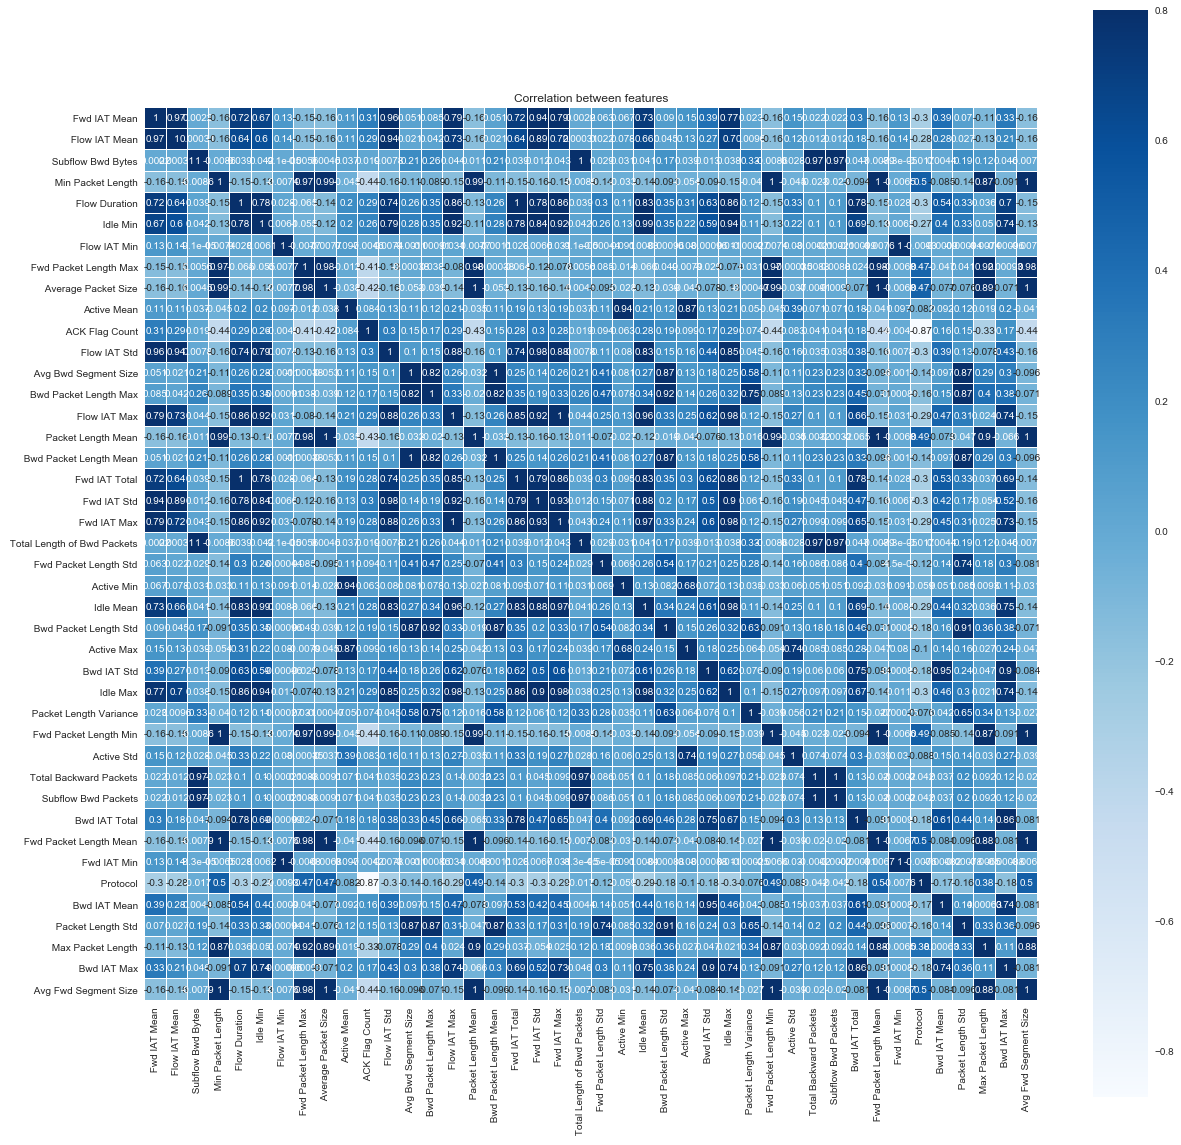

In [91]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_mat, vmax=.8, linewidths=0.01, square=True, annot=True, cmap='Blues', linecolor='white')
plt.title('Correlation between features')